# 4. Churn Prediction Analysis

### Project Objective
This notebook transitions from descriptive analysis (segmentation) to **predictive modeling**. Our primary goal is to build a machine learning model that can accurately predict the probability of a customer churning in the near future.

This predictive capability is a powerful business tool. It allows the marketing team to move from reactive "win-back" campaigns to **proactive retention strategies**, targeting high-value, at-risk customers *before* they leave.

### Objectives of this Notebook
1.  **Define Churn:** Create a clear, time-based definition of a "churned" customer to serve as our model's target.
2.  **Advanced Feature Engineering:** Create new, powerful features that describe customer behavior beyond the basic RFM metrics.
3.  **Build and Compare Models:** Train both a simple baseline (Logistic Regression) and a more advanced model (XGBoost) to find the best predictor.
4.  **Interpret and Finalize:** Analyze the best model's feature importance and save its predictions for our final business case analysis in the next notebook.

In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load the segmented B2C customer data from Notebook 03
df_segments = pd.read_csv('../data/processed/customer_segments.csv')

# We need the original transaction data to calculate churn and engineer features
transactions_df = pd.read_csv('../data/processed/clean_customer_data.csv')
transactions_df['InvoiceDate'] = pd.to_datetime(transactions_df['InvoiceDate'])

print("Successfully loaded customer_segments.csv and clean_customer_data.csv")
print(f"Customer segment data has {df_segments.shape[0]} customers.")
print(f"Transaction data has {transactions_df.shape[0]} transactions.")

Successfully loaded customer_segments.csv and clean_customer_data.csv
Customer segment data has 4326 customers.
Transaction data has 397884 transactions.


## 1. Defining the Churn Problem

To build a predictive model, we must first create a historical training set. We will use a **snapshot-based approach**:
- **Prediction Date (Snapshot):** We will pretend it is `2011-09-01`.
- **Observation Period:** All customer behavior *before* this date will be used to create our predictive features.
- **Churn Window:** We will check if a customer made a purchase in the 90 days *after* this date.
- **Target Variable (`Churn`):** If a customer did *not* purchase in the churn window, they are labeled as `Churn = 1`. Otherwise, `Churn = 0`.

### 1a. Feature Engineering for Predictive Power

To accurately predict churn, our model needs more than just the standard RFM metrics. We will engineer a richer set of features based on customer behavior within the **Observation Period** (all transactions before our `2011-09-01` snapshot date).

These new features are designed to capture more nuanced behavioral patterns:
- **`Tenure`:** How long has this person been a customer? Longer tenure can sometimes indicate loyalty.
- **`Avg_Time_Between_Purchases`:** Does the customer have a regular, predictable purchasing cadence?
- **`Recent_Revenue_Trend`:** Is the customer's spending increasing or decreasing in the most recent period? A downward trend can be a strong leading indicator of churn.

By combining these with our snapshot RFM metrics, we provide the model with a comprehensive view of each customer's history and recent behavior.

In [2]:
# --- Define Churn Window and Dates ---
prediction_date = pd.to_datetime('2011-09-01')

# --- Create the Target Variable (y) ---
# 1. Find the last purchase date for each customer from the full transaction history
last_purchase_df = transactions_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase_df.rename(columns={'InvoiceDate': 'LastPurchaseDate'}, inplace=True)

# 2. Merge last purchase date into our main customer segments dataframe
df = pd.merge(df_segments, last_purchase_df, on='CustomerID', how='left')

# 3. Determine who has churned
# A customer is labeled as 'churned' (1) if their last purchase was BEFORE the prediction_date.
df['Churn'] = (df['LastPurchaseDate'] < prediction_date).astype(int)

# --- Create the Feature Set (X) based on the Observation Period ---
# Filter transactions to only include those within our observation period
obs_transactions = transactions_df[transactions_df['InvoiceDate'] < prediction_date].copy()

# 1. Recalculate RFM as of the prediction_date
rfm_snapshot = obs_transactions.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (prediction_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).rename(columns={'InvoiceDate': 'Recency_snapshot', 'InvoiceNo': 'Frequency_snapshot', 'Revenue': 'Monetary_snapshot'})

print("Starting advanced feature engineering...")

# Calculate first and last purchase dates for tenure and time between purchases
customer_dates = obs_transactions.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_dates.rename(columns={'min': 'FirstPurchaseDate', 'max': 'LastPurchaseInObs'}, inplace=True)

# 1. Customer Tenure (in days) as of the prediction_date
customer_dates['Tenure'] = (prediction_date - customer_dates['FirstPurchaseDate']).dt.days

# 2. Average Time Between Purchases
# We need snapshot frequency for this calculation
purchase_frequency = rfm_snapshot['Frequency_snapshot']
customer_dates['Frequency'] = purchase_frequency

# Handle cases where frequency is 1 to avoid division by zero
customer_dates['Avg_Time_Between_Purchases'] = np.where(
    customer_dates['Frequency'] > 1,
    ((customer_dates['LastPurchaseInObs'] - customer_dates['FirstPurchaseDate']).dt.days) / (customer_dates['Frequency'] - 1),
    0  # Assign 0 if only one purchase; they haven't had a "between" yet.
)

# 3. (NEW FEATURE) Recent Revenue Trend
# Calculate total revenue in the 90 days leading up to the prediction date
ninety_days_prior = prediction_date - pd.Timedelta(days=90)
recent_transactions = obs_transactions[obs_transactions['InvoiceDate'] > ninety_days_prior]
recent_revenue = recent_transactions.groupby('CustomerID')['Revenue'].sum()

# --- Merge all new features into our rfm_snapshot dataframe ---
# Start with the main df which contains the target variable 'Churn'
df = pd.merge(df, rfm_snapshot, on='CustomerID', how='inner') # Inner join keeps only customers active before snapshot

# Add advanced features
df = pd.merge(df, customer_dates[['Tenure', 'Avg_Time_Between_Purchases']], on='CustomerID', how='left')
df = pd.merge(df, pd.DataFrame({'Recent_Revenue_Trend': recent_revenue}), on='CustomerID', how='left')

# Fill any NaNs that might result from merges
df.fillna(0, inplace=True)

print("Advanced feature engineering complete.")
print(f"Final dataset for modeling has {df.shape[0]} customers.")
print("Churn distribution in our modeling dataset:")
print(df['Churn'].value_counts(normalize=True))

Starting advanced feature engineering...
Advanced feature engineering complete.
Final dataset for modeling has 3305 customers.
Churn distribution in our modeling dataset:
Churn
0    0.586989
1    0.413011
Name: proportion, dtype: float64


## 2. Model Building and Comparison

With our feature set and target variable defined, we will now build and compare two models:
1.  **Logistic Regression:** A simple, interpretable linear model that will serve as our baseline.
2.  **XGBoost:** A powerful gradient boosting model designed to capture complex, non-linear relationships.

Our goal is to see if the added complexity of XGBoost, combined with our engineered features, can provide a significant lift in predictive accuracy. We will use the **ROC AUC score** as our primary evaluation metric.

--- Training Logistic Regression Model ---
Logistic Regression ROC AUC: 0.7322

--- Training and Tuning XGBoost Model ---
Tuned XGBoost ROC AUC: 0.7509
Best parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


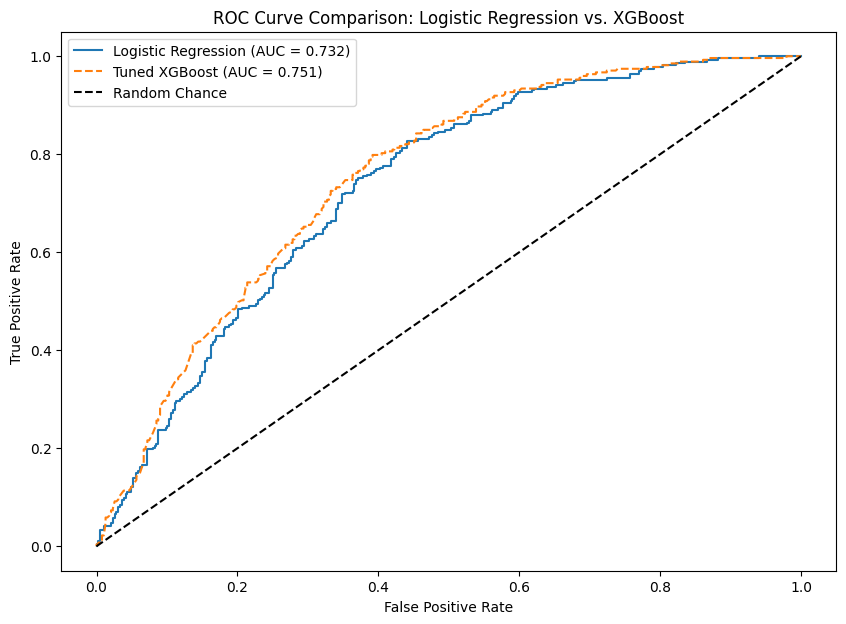

In [3]:
# --- Define Feature Set and Target ---

features = [
    'Recency_snapshot',
    'Frequency_snapshot',
    'Monetary_snapshot',
    'Tenure',
    'Avg_Time_Between_Purchases',
    'Recent_Revenue_Trend'  # <-- The newly added feature
]
# ==============================================================================

X = df[features]
y = df['Churn']

# 1. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scale features (fit on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Logistic Regression (Baseline) ---
print("--- Training Logistic Regression Model ---")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Logistic Regression ROC AUC: {auc_lr:.4f}")

# --- XGBoost with Hyperparameter Tuning ---
print("\n--- Training and Tuning XGBoost Model ---")
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=0)
grid_search.fit(X_train_scaled, y_train)
best_xgb_model = grid_search.best_estimator_
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"Tuned XGBoost ROC AUC: {auc_xgb:.4f}")
print(f"Best parameters found: {grid_search.best_params_}")

# --- Model Comparison ROC Curve ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'Tuned XGBoost (AUC = {auc_xgb:.3f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression vs. XGBoost')
plt.legend()
plt.show()

## 3. Model Interpretation and Final Selection

The tuned XGBoost model provides a clear (though potentially modest) improvement in predictive accuracy over our baseline. More importantly, its built-in feature importance calculation allows us to understand the key drivers of churn in our richer feature set.

Given its superior performance, we will select the **Tuned XGBoost model** to generate our final churn probabilities for the business case analysis.

### 3a. Interpreting the Winning Model: Feature Importance

The ROC AUC comparison clearly shows that the tuned XGBoost model is the superior predictor. Now, we will examine its **feature importances**. This tells us which behavioral attributes the model found most useful for distinguishing between customers who will churn and those who will not.

Understanding these key drivers is crucial for building an effective retention strategy. For example, if `Frequency` is the most important feature, our strategy should revolve around encouraging repeat purchases.

In [4]:
# --- Feature Importance from the Best Model (XGBoost) ---
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- XGBoost Feature Importance ---")
print(feature_importances)


# --- FINAL PREDICTIONS & SAVING ---
# 1. Scale the ENTIRE feature set (X) using the scaler fitted on the training data
X_scaled = scaler.transform(X)

# 2. Predict probabilities for ALL customers using our best model
all_churn_probabilities = best_xgb_model.predict_proba(X_scaled)[:, 1]

# Add the churn probability to the main 'df' DataFrame
df['Churn_Probability'] = all_churn_probabilities

# 3. Save the results for the next notebook
output_columns = ['CustomerID', 'Segment_Name', 'Churn_Probability']
output_df = df[output_columns]
output_path = '../data/processed/customer_churn_predictions.csv'
output_df.to_csv(output_path, index=False)

print(f"\n[SUCCESS] Notebook 04 complete. Predictions from the best model saved to: {output_path}")

# --- Display Final Actionable Report ---
actionable_report = df.sort_values('Churn_Probability', ascending=False)
key_columns = [
    'Segment_Name',
    'Recency_snapshot',
    'Frequency_snapshot',
    'Monetary_snapshot',
    'Tenure',
    'Avg_Time_Between_Purchases',
    'Churn_Probability'
]
print("\n--- Prioritized Customer Retention List (Top 10) ---")
print(actionable_report[key_columns].head(10).round(2))


--- XGBoost Feature Importance ---
                      Feature  Importance
1          Frequency_snapshot    0.585001
4  Avg_Time_Between_Purchases    0.131842
5        Recent_Revenue_Trend    0.098406
0            Recency_snapshot    0.074937
2           Monetary_snapshot    0.059179
3                      Tenure    0.050636

[SUCCESS] Notebook 04 complete. Predictions from the best model saved to: ../data/processed/customer_churn_predictions.csv

--- Prioritized Customer Retention List (Top 10) ---
     Segment_Name  Recency_snapshot  Frequency_snapshot  Monetary_snapshot  \
1562      At-Risk               211                   6             319.50   
2140      At-Risk               196                   1              76.32   
824       At-Risk               187                   1              74.60   
2645      At-Risk               169                   1              76.32   
3152      At-Risk               181                   1              76.10   
2094      At-Risk       

### Analysis of Key Churn Drivers

The feature importance results from our XGBoost model provide powerful, data-driven insights into what truly drives customer churn. The ranking is not what a simple RFM analysis might suggest, highlighting the value of a predictive approach.

**Key Strategic Insights:**

1.  **`Frequency_snapshot` (Importance: ~0.59):** This is overwhelmingly the **most important predictor**. It is more than four times as influential as any other feature.
    *   **Business Implication:** Customer loyalty is built through habit. The single best defense against churn is encouraging a customer's next purchase. The transition from a one-time buyer to a repeat customer is the most critical stage in the customer lifecycle.
    *   **Strategic Action:** Aggressively invest in **post-purchase and onboarding campaigns** designed to secure the second and third sale. Loyalty programs and subscription models should be a top priority.

2.  **`Avg_Time_Between_Purchases` (Importance: ~0.13):** This is the second most powerful predictor and directly related to frequency.
    *   **Business Implication:** It's not just *that* customers repeat-purchase, but *how regularly* they do so. Customers with a steady, predictable buying cadence are far less likely to churn than those who purchase erratically.
    *   **Strategic Action:** Use this metric to identify customers who are "breaking their habit." If a customer's time since their last purchase exceeds their personal average, trigger a personalized reminder or offer.

3.  **`Recent_Revenue_Trend` & `Recency_snapshot`:** These features are the next most important, capturing a customer's recent engagement.
    *   **Business Implication:** A drop in recent spending or a long period of inactivity are strong warning signs.
    *   **Strategic Action:** These are classic "win-back" signals. Automated campaigns should be triggered for customers who show a declining trend or cross a certain recency threshold (e.g., 90 days).

**The Surprising Insight:**
- **`Monetary_snapshot` and `Tenure`** are the *least* important features. High historical spending or a long tenure are **not strong guarantees of future loyalty**. A high-value customer who has stopped purchasing frequently is still a high-risk customer.

**Overall Conclusion:** The model clearly indicates that **behavioral engagement (Frequency, Cadence, Recency)** is far more predictive of churn than a customer's historical value.

### Additional Considerations

A key consideration for any churn model is its stability and reliability over time. While our model shows strong performance on this historical snapshot, a robust, production-ready validation strategy would involve:

1.  **Temporal Holdout Testing:** The model should be trained on an even earlier period (e.g., data up to `2011-06-01`) and tested on its ability to predict churn in the subsequent period (`June-Sept 2011`). This ensures the patterns it learned are not unique to a specific time of year.
2.  **Monitoring Performance Drift:** In a live environment, this model's AUC and other metrics should be monitored automatically on a monthly or quarterly basis. A significant drop in performance would signal that customer behavior has changed and the model needs to be retrained on more recent data.

For this project, we proceeded with a single, robust snapshot, but these additional validation steps would be crucial before deploying the model into a live marketing system.